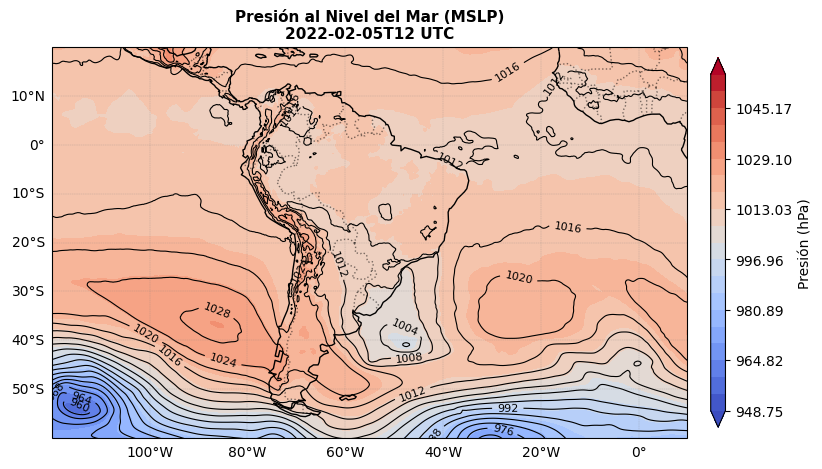

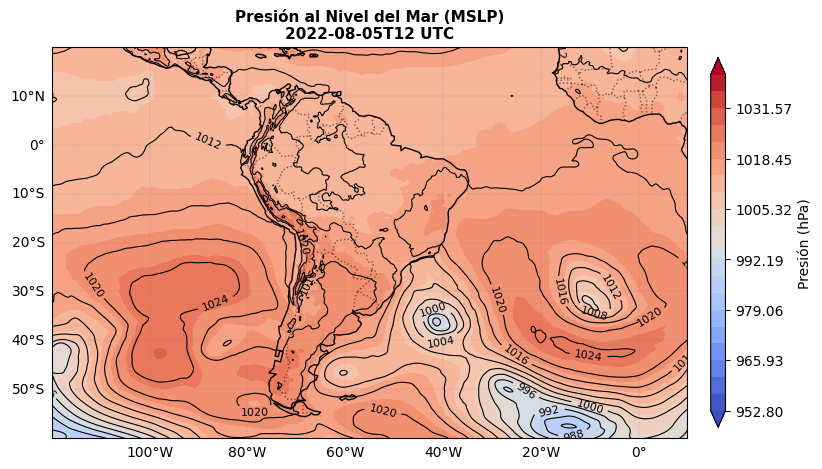

In [32]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# 1. Cargar datos (Asegúrate de que la ruta sea la de tu archivo ERA5)
# El archivo debe contener la variable 'msl'
ds = xr.open_dataset(r"D:\sinop\nc\slp.22.nc")

# 2. Configuración para MSLP
# En ERA5 la variable suele llamarse 'msl'. La convertimos a hPa inmediatamente.
ds_hpa = ds.msl / 100.0

fechas_objetivo = ['2022-02-05 T12:00:00', '2022-08-05 T12:00:00']
intervalo =4  # Intervalo típico de 4 hPa para mapas sinópticos

for fecha in fechas_objetivo:
    # Seleccionamos el paso de tiempo exacto
    step_data = ds_hpa.sel(valid_time=fecha, method='nearest')
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Definir límites de color basados en la data del momento
    v_min, v_max = np.nanmin(step_data), np.nanmax(step_data)
    clevs_fill = np.linspace(v_min, v_max, 21)

    # Manejo de longitud cíclica para evitar línea en blanco
    # En ERA5 las coordenadas suelen ser 'longitude' y 'latitude'
    data_cyc, lon_cyc = add_cyclic_point(step_data.values, coord=step_data.longitude)
    
    # Configuración del mapa (Misma extensión de tu video)
    ax.set_extent([-120, 10, -60, 20], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    
    # Sombreado (contourf)
    im = ax.contourf(
        lon_cyc, step_data.latitude, data_cyc,
        levels=clevs_fill,
        transform=ccrs.PlateCarree(),
        # Cambia esto en tu ax.contourf:
        cmap = "coolwarm",
        extend='both'
    )
    
    # Barra de colores
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.03, aspect=25, shrink=0.8)
    cbar.set_label('Presión (hPa)', fontsize=10)

    # Contornos (contour) - Usando el intervalo de 4 hPa
    levels_cnt = np.arange(np.floor(v_min/intervalo)*intervalo, v_max + intervalo, intervalo)
    cs = ax.contour(
        lon_cyc, step_data.latitude, data_cyc,
        levels=levels_cnt,
        colors="black",
        linewidths=0.8,
        transform=ccrs.PlateCarree()
    )
    ax.clabel(cs, fmt="%d", fontsize=8, inline=True)

    # Títulos y estética
    fecha_str = np.datetime_as_string(step_data.valid_time.values, unit='h')
    ax.set_title(f"Presión al Nivel del Mar (MSLP)\n{fecha_str} UTC", fontsize=11, fontweight='bold')
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    plt.show()

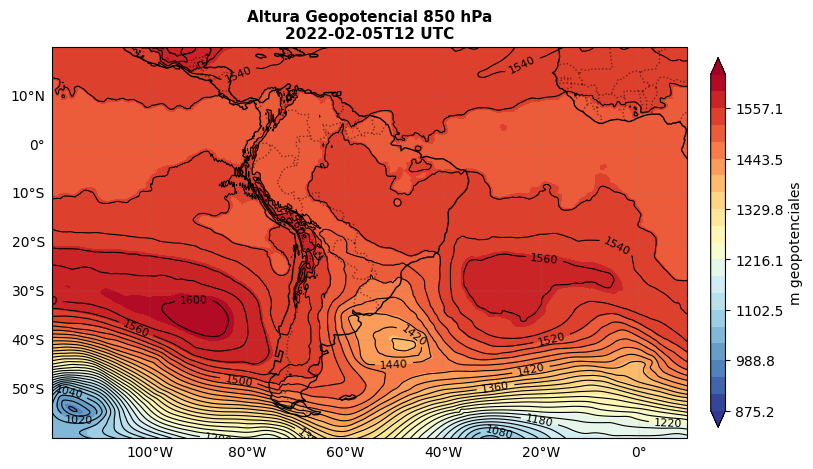

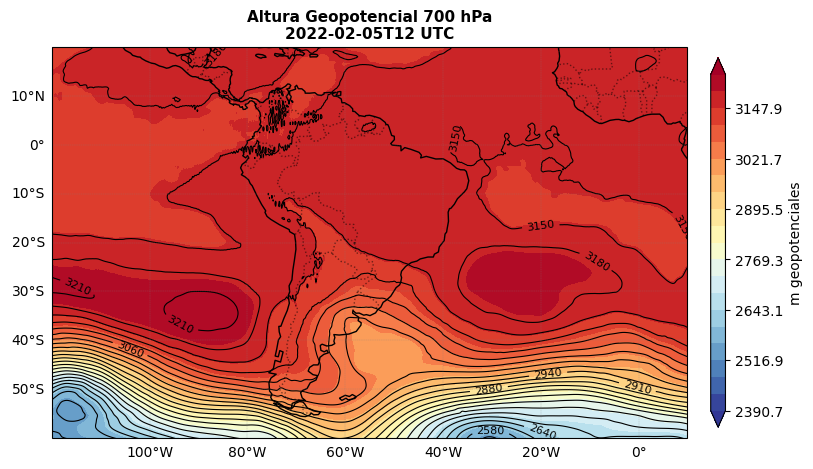

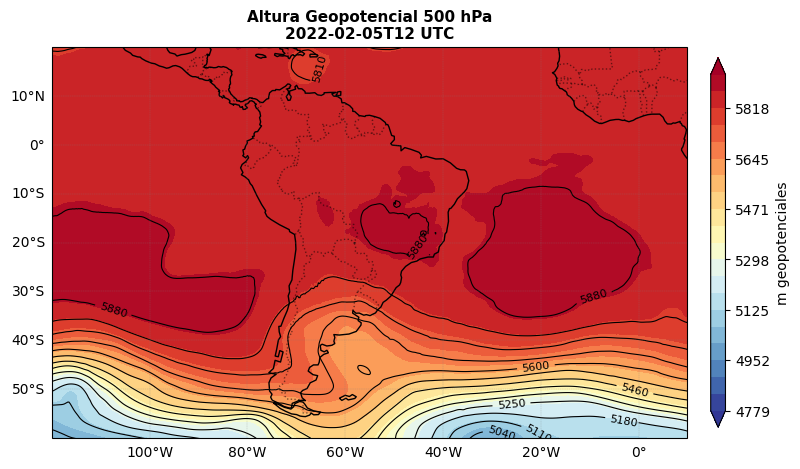

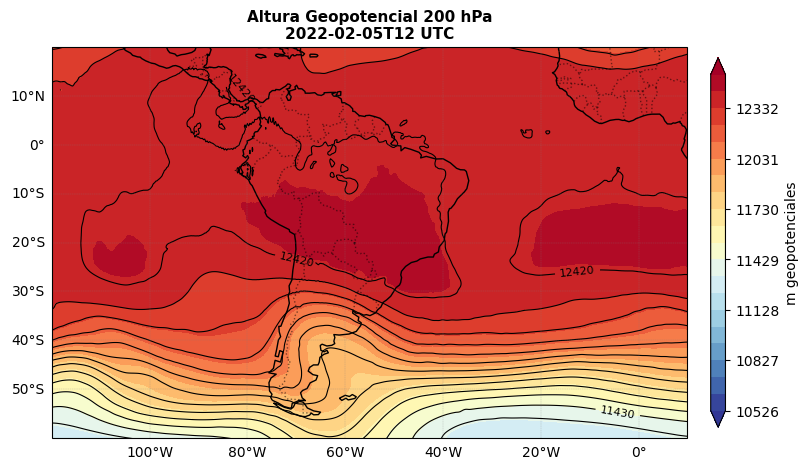

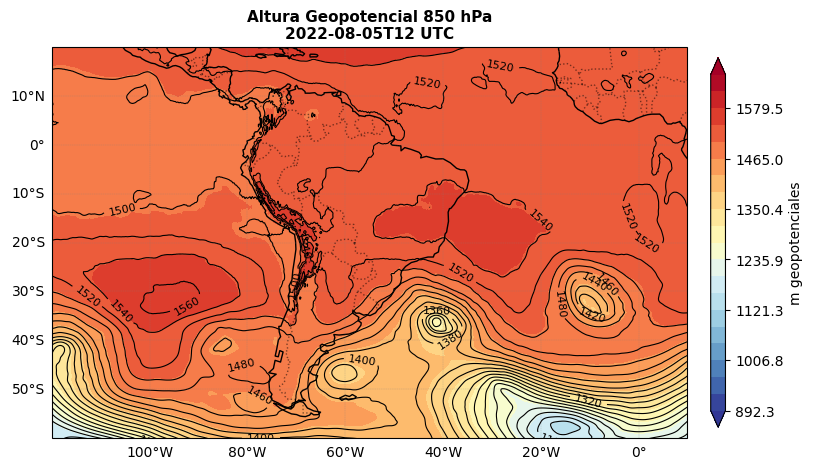

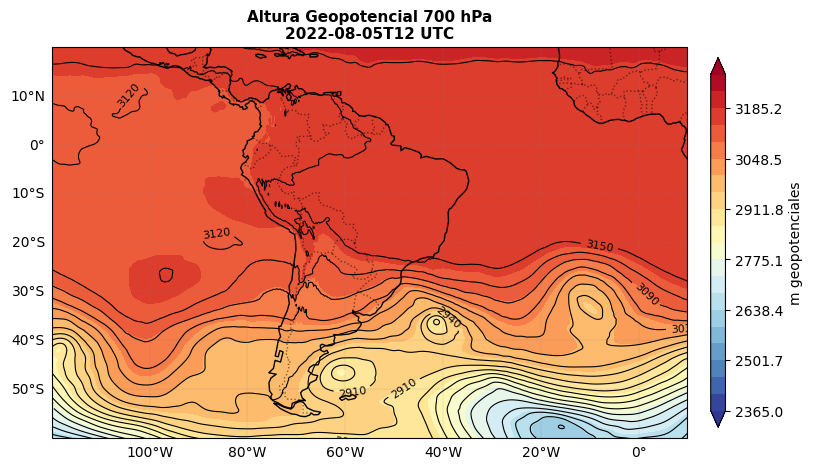

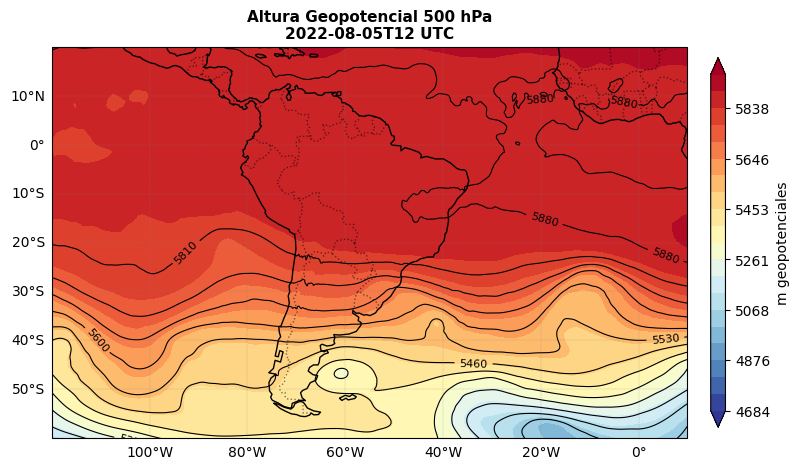

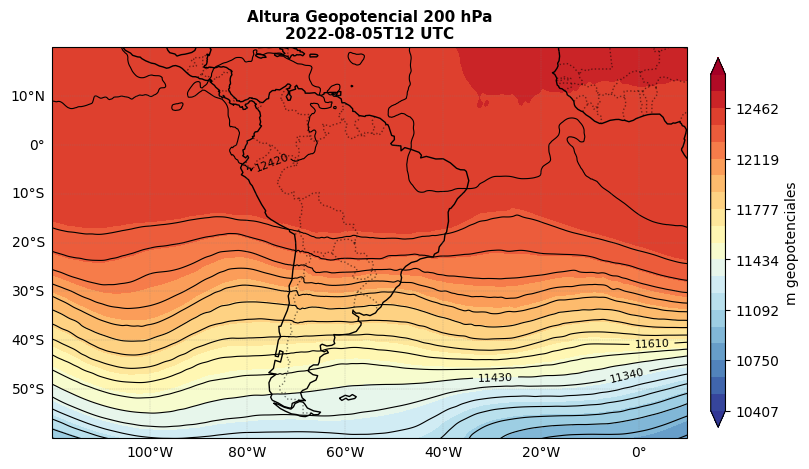

In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# 1. Cargar datos (Asegúrate de que tu archivo de ERA5 tenga los niveles 850, 700, 500, 200)
dg = xr.open_dataset(r"D:\sinop\nc\geo22.nc")

# 2. Configuración general
niveles = [850, 700, 500, 200]
intervalos = {850: 20, 700: 30, 500: 70, 200: 90}
fechas_objetivo = ['2022-02-05T12:00:00', '2022-08-05T12:00:00' ]

# En ERA5 la variable de geopotencial es 'z'. 
# Se debe dividir por 9.80665 para obtener metros geopotenciales (gpm)
ds_gpm = dg.z / 9.80665

for fecha in fechas_objetivo:
    for nivel in niveles:
        # Selección de nivel y fecha exacta
        step_data = ds_gpm.sel(pressure_level=nivel, valid_time=fecha, method='nearest')
        
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        intervalo = intervalos[nivel]

        # Límites para la barra de colores (basados en el nivel actual)
        v_min, v_max = np.nanmin(step_data), np.nanmax(step_data)
        clevs_fill = np.linspace(v_min, v_max, 21)

        # Manejo de longitud cíclica (ERA5 usa longitude/latitude)
        data_cyc, lon_cyc = add_cyclic_point(step_data.values, coord=step_data.longitude)
        
        # Configuración del mapa
        ax.set_extent([-120, 10, -60, 20], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
        
        # Sombreado (contourf)
        im = ax.contourf(
            lon_cyc, step_data.latitude, data_cyc,
            levels=clevs_fill,
            transform=ccrs.PlateCarree(),
            cmap="RdYlBu_r",
            extend='both'
        )
        
        # Barra de colores
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.03, aspect=25, shrink=0.8)
        cbar.set_label('m geopotenciales', fontsize=10)

        # Contornos (contour)
        levels_cnt = np.arange(np.floor(v_min/intervalo)*intervalo, v_max + intervalo, intervalo)
        cs = ax.contour(
            lon_cyc, step_data.latitude, data_cyc,
            levels=levels_cnt,
            colors="black",
            linewidths=0.8,
            transform=ccrs.PlateCarree()
        )
        ax.clabel(cs, fmt="%d", fontsize=8, inline=True)

        # Títulos y estética
        fecha_str = np.datetime_as_string(step_data.valid_time.values, unit='h')
        ax.set_title(f"Altura Geopotencial {nivel} hPa\n{fecha_str} UTC", fontsize=11, fontweight='bold')
        
        gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
        # Guardar o mostrar
        # plt.savefig(f"hgt_{nivel}_{fecha_str.replace(':','')}.png", dpi=150)
        plt.show()